Take September and as City Milano

In [143]:
import pandas as pd
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import lars_path
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [114]:
airbnb = pd.read_csv("/Users/jacopobinati/Desktop/Prediction ML/assignment2/listings_Oct.csv")
airbnb.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,9630344,https://www.airbnb.com/rooms/9630344,20231001204715,2023-10-02,city scrape,Rental unit in Brooklyn · ★4.80 · 1 bedroom ·...,Enjoy your own private bedroom in our 2 bedroo...,Easy access to subway. Trendy and yet quiet.,https://a0.muscache.com/pictures/496cf3f1-7d0d...,47783628,...,5.00,4.80,5.00,NaN,f,1,0,1,0,0.06
1,3533741,https://www.airbnb.com/rooms/3533741,20231001204715,2023-10-02,previous scrape,Rental unit in New York · 1 bedroom · 1 bed · ...,Come stay in the heart of historic Hells Kitch...,NaN,https://a0.muscache.com/pictures/45157664/862a...,17791294,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
2,9731039,https://www.airbnb.com/rooms/9731039,20231001204715,2023-10-02,previous scrape,Rental unit in Queens · Studio · 1 bed · 1 bath,Studio Apartment in the heart of Sunnyside: of...,NaN,https://a0.muscache.com/pictures/81a96b92-d357...,50213378,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,21736164,https://www.airbnb.com/rooms/21736164,20231001204715,2023-10-02,previous scrape,Rental unit in Brooklyn · 1 bedroom · 1 bed · ...,"Light-filled, high-ceilinged 1BR brownstone ap...","The neighborhood is vibrant, multicultural, an...",https://a0.muscache.com/pictures/4e3ee5e2-baa1...,4298654,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.03
4,22280002,https://www.airbnb.com/rooms/22280002,20231001204715,2023-10-01,city scrape,Rental unit in Brooklyn · ★4.98 · 1 bedroom · ...,This is a comfortable super spacious sunny 1 b...,Welcome to the enchanting neighborhood of Stuy...,https://a0.muscache.com/pictures/b187bce7-ded7...,67373899,...,4.91,4.94,4.92,NaN,f,1,1,0,0,1.26


In [115]:
column_info = pd.DataFrame({
    "ID": range(len(airbnb.columns)),
    "Variable": airbnb.columns
})
print(column_info)

    ID                                      Variable
0    0                                            id
1    1                                   listing_url
2    2                                     scrape_id
3    3                                  last_scraped
4    4                                        source
..  ..                                           ...
70  70                calculated_host_listings_count
71  71   calculated_host_listings_count_entire_homes
72  72  calculated_host_listings_count_private_rooms
73  73   calculated_host_listings_count_shared_rooms
74  74                             reviews_per_month

[75 rows x 2 columns]


### Cleaning Dataset
#### After indexing the columns, i dropped some of them (can be checked under). Moreover, I decided to keep a threshold of 40% for varibales with NAs. If we are too narrow, we will reduce the number of variable drastically.

In [116]:
columns_to_drop = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
    11, 12, 13, 15, 20,
    21,
    44, 45, 46, 47,
    56, 60,
    61, 69
]
airbnb_dropped = airbnb.drop(columns=airbnb.columns[columns_to_drop])
threshold = 0.4
airbnb_nmiss = airbnb_dropped.loc[:, airbnb_dropped.isnull().mean() < threshold]
print(airbnb_nmiss.describe())
airbnb2 = airbnb_nmiss.copy()
airbnb2['price'] = airbnb2['price'].replace('[\$,]', '', regex=True).astype(float)

airbnb2['price'] = pd.to_numeric(airbnb2['price'], errors='coerce')
airbnb2['ln_price'] = np.log(airbnb2['price'])

       host_listings_count  host_total_listings_count      latitude   
count         38787.000000               38787.000000  38792.000000  \
mean            141.639286                 228.431021     40.729379   
std             625.516773                 977.805887      0.056725   
min               1.000000                   1.000000     40.500314   
25%               1.000000                   1.000000     40.688790   
50%               2.000000                   3.000000     40.726290   
75%               7.000000                  10.000000     40.762672   
max            4559.000000                8820.000000     40.911380   

          longitude  accommodates          beds  minimum_nights   
count  38792.000000  38792.000000  38129.000000    38792.000000  \
mean     -73.945829      2.907249      1.650214       30.639977   
std        0.055115      2.101448      1.169714       26.633260   
min      -74.251907      1.000000      1.000000        1.000000   
25%      -73.982820      

/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [117]:
for column in airbnb2.columns:
    value_type = type(airbnb2.loc[0, column])
    print(f"Column '{column}' has values of type: {value_type}")

Column 'host_response_rate' has values of type: <class 'float'>
Column 'host_acceptance_rate' has values of type: <class 'float'>
Column 'host_is_superhost' has values of type: <class 'str'>
Column 'host_thumbnail_url' has values of type: <class 'str'>
Column 'host_listings_count' has values of type: <class 'numpy.float64'>
Column 'host_total_listings_count' has values of type: <class 'numpy.float64'>
Column 'host_verifications' has values of type: <class 'str'>
Column 'host_has_profile_pic' has values of type: <class 'str'>
Column 'host_identity_verified' has values of type: <class 'str'>
Column 'neighbourhood_cleansed' has values of type: <class 'str'>
Column 'neighbourhood_group_cleansed' has values of type: <class 'str'>
Column 'latitude' has values of type: <class 'numpy.float64'>
Column 'longitude' has values of type: <class 'numpy.float64'>
Column 'property_type' has values of type: <class 'str'>
Column 'room_type' has values of type: <class 'str'>
Column 'accommodates' has valu

In [118]:
airbnb2

,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ln_price
0,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/5c087...,1.0,2.0,"['email', 'phone']",t,f,Bushwick,...,5.00,5.00,4.80,5.00,1,0,1,0,0.06,4.174387
1,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/e204b...,1.0,1.0,"['email', 'phone']",t,t,Hell's Kitchen,...,NaN,NaN,NaN,NaN,1,0,1,0,NaN,4.700480
2,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/65d77...,1.0,1.0,"['email', 'phone']",t,f,Sunnyside,...,NaN,NaN,NaN,NaN,1,1,0,0,NaN,4.595120
3,NaN,NaN,f,https://a0.muscache.com/im/users/4298654/profi...,1.0,2.0,"['email', 'phone', 'work_email']",t,t,Bedford-Stuyvesant,...,5.00,5.00,5.00,5.00,1,1,0,0,0.03,4.248495
4,NaN,100%,t,https://a0.muscache.com/im/pictures/user/41ec9...,1.0,1.0,"['email', 'phone']",t,t,Bedford-Stuyvesant,...,4.95,4.91,4.94,4.92,1,1,0,0,1.26,5.135798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38787,100%,94%,t,https://a0.muscache.com/im/users/21020951/prof...,1.0,6.0,"['email', 'phone']",t,t,Bedford-Stuyvesant,...,5.00,4.83,4.61,4.61,1,0,1,0,0.34,4.553877
38788,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/8daf5...,2.0,3.0,"['email', 'phone']",t,t,Upper West Side,...,5.00,5.00,5.00,5.00,2,0,2,0,0.01,4.317488
38789,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/8daf5...,2.0,3.0,"['email', 'phone']",t,t,Upper West Side,...,4.71,4.86,5.00,4.86,2,0,2,0,0.07,4.442651
38790,90%,100%,t,https://a0.muscache.com/im/pictures/user/9a273...,2.0,6.0,"['email', 'phone']",t,t,Long Island City,...,4.80,5.00,4.60,4.40,2,2,0,0,0.22,4.976734


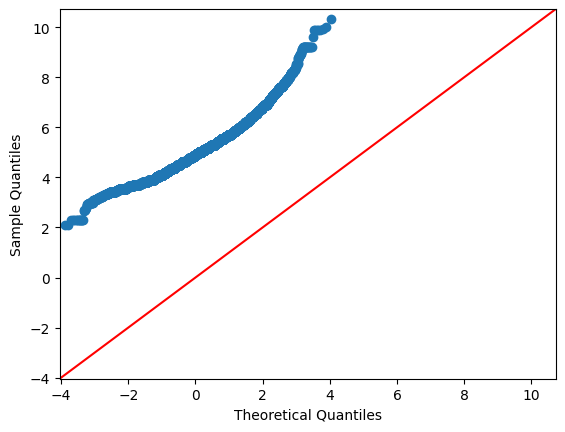

In [153]:
import pylab as py 
sm.qqplot(airbnb2['ln_price'], line ='45') 
py.show() 

In [ ]:
# check correlation among all the variables in the datset. 
def correlation 

sns.heatmap(corr , )

### Plotting some Graphs

/var/folders/6t/d3d0rh5d1rd426bk9g_mnhd00000gn/T/ipykernel_14711/232840041.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(airbnb2['longitude'],airbnb2['latitude'], s=7,linewidth=0,cmap="Blues")


Text(0.5, 1.0, 'Geospatial House Location')

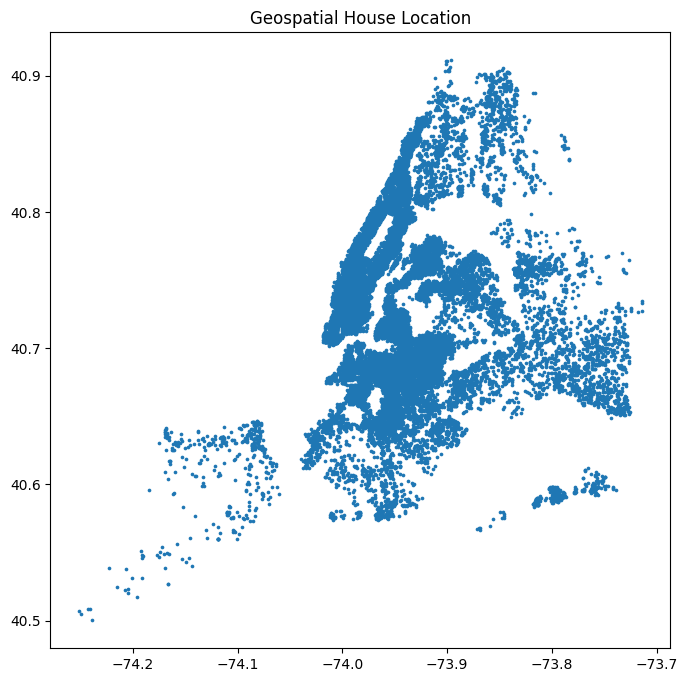

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(airbnb2['longitude'],airbnb2['latitude'], s=7,linewidth=0,cmap="Blues")
ax.set_title('Geospatial House Location')

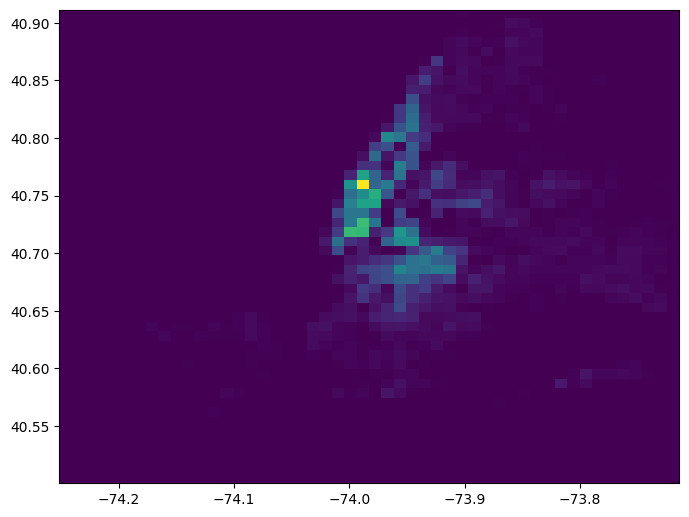

Heatmap of house offerings, red means higher density


In [122]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
heatmap, xedges, yedges = np.histogram2d(airbnb2['longitude'], airbnb2['latitude'], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()
print("Heatmap of house offerings, red means higher density")

In [121]:
print(airbnb2['review_scores_value'].value_counts())

review_scores_value
5.00    6343
4.00    1339
4.50    1198
4.67     976
4.75     792
        ... 
3.53       1
3.85       1
3.61       1
3.45       1
3.84       1
Name: count, Length: 165, dtype: int64


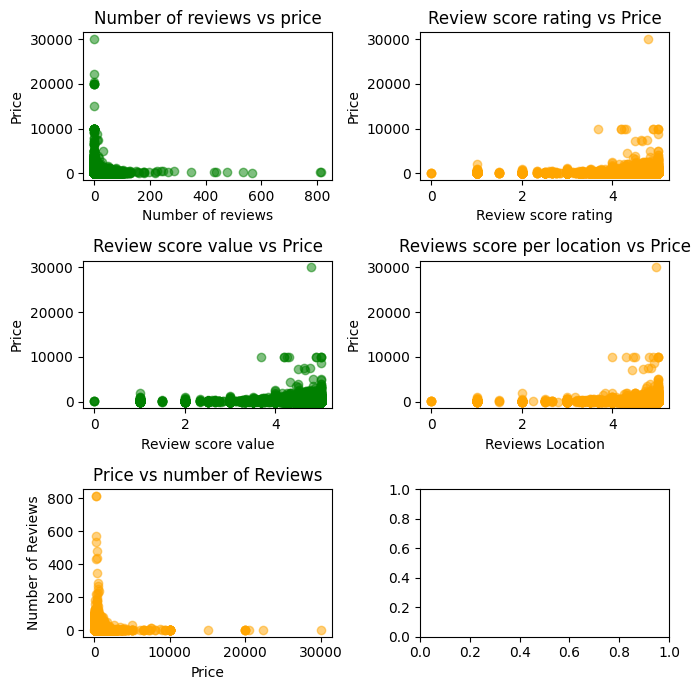

In [128]:
def plot_scatter(x,y, title, x_label, y_label, face, axes):
    
    axes.scatter(x,y,color=face,alpha=0.5)
    axes.set_title(title)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
  
    return axes
    
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(7, 7))
ax1 = plot_scatter(airbnb2.number_of_reviews_ltm,airbnb2.price,
                'Number of reviews vs price', 
                'Number of reviews', 'Price',
                'green', 
                ax1)

ax2 = plot_scatter(airbnb2.review_scores_value,airbnb2.price,
                'Review score rating vs Price', 
                'Review score rating', 'Price',
                'orange', 
                ax2)

ax3 = plot_scatter(airbnb2.review_scores_value,airbnb2.price,
                'Review score value vs Price', 
                'Review score value', 'Price', 
                'green', 
                ax3)

ax4 = plot_scatter(airbnb2.review_scores_location,airbnb2.price,
                'Reviews score per location vs Price', 
                'Reviews Location', 'Price',
                'orange', 
                ax4)

ax5 = plot_scatter(airbnb2.price,airbnb2.number_of_reviews_ltm,
                'Price vs number of Reviews', 
                'Price','Number of Reviews',
                'orange', ax5)



plt.tight_layout()
plt.show()

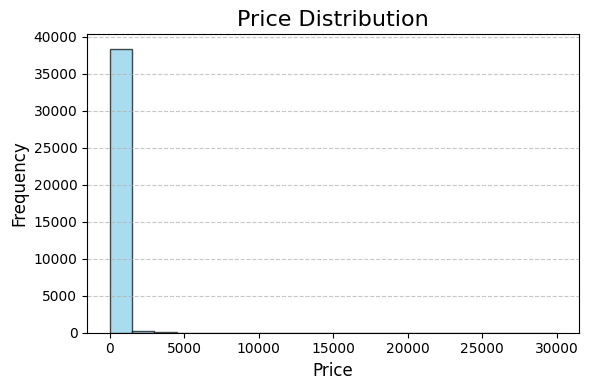

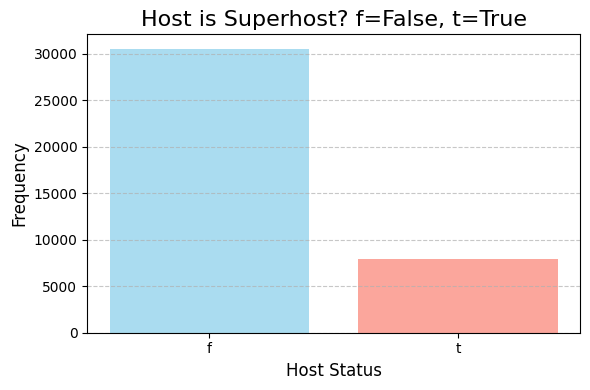

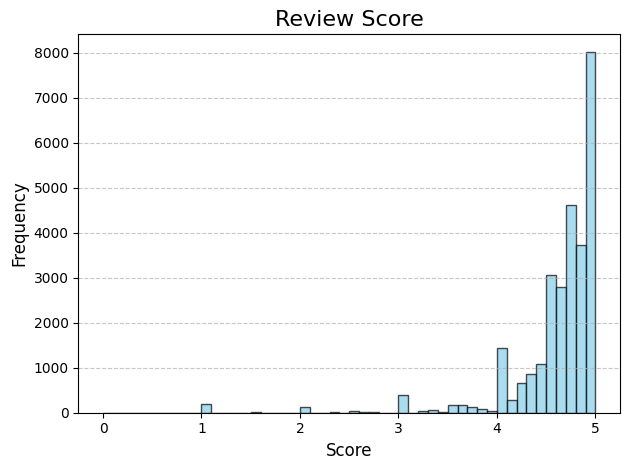

In [141]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(airbnb2['price'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(airbnb2['host_is_superhost'].value_counts().index, airbnb2['host_is_superhost'].value_counts().values,
        color=['skyblue', 'salmon'], alpha=0.7)
plt.title('Host is Superhost? f=False, t=True', fontsize=16)
plt.xlabel('Host Status', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

bin_edges = np.arange(airbnb2['review_scores_value'].min(), airbnb2['review_scores_value'].max() + 0.1, 0.1)

plt.hist(airbnb2['review_scores_value'], bins=bin_edges, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Review Score', fontsize=16)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Dealing with Amenities

In [130]:
print(airbnb2['amenities'].head(1))

amenities = airbnb2['amenities'].str.split(',')
amenities_table = pd.Series([item for sublist in amenities for item in sublist]).value_counts()
sorted_table = amenities_table.sort_values(ascending=False)
print(sorted_table.head())

0    ["Body soap", "Dryer", "Refrigerator", "Wifi",...
Name: amenities, dtype: object
 "Wifi"                     35181
 "Kitchen"                  32179
 "Essentials"               31178
 "Carbon monoxide alarm"    29835
 "Hangers"                  27395
Name: count, dtype: int64


### Transform amenities into a binary indicator matrix

In [131]:
amenities_table = airbnb2['amenities'].str.get_dummies(sep=',')
print(amenities_table.head())
amenities_table.describe()

     Bodywash body soap"    Head and Shoulders Dandruff Shampoo shampoo"   
0                      0                                               0  \
1                      0                                               0   
2                      0                                               0   
3                      0                                               0   
4                      0                                               0   

     body soap"   " Bertazzoni stainless steel oven"   
0             0                                    0  \
1             0                                    0   
2             0                                    0   
3             0                                    0   
4             0                                    0   

    " Bose Speaker Bluetooth sound system"   
0                                        0  \
1                                        0   
2                                        0   
3                     

,"Bodywash body soap""","Head and Shoulders Dandruff Shampoo shampoo""","body soap""",""" Bertazzoni stainless steel oven""",""" Bose Speaker Bluetooth sound system""",""" Bowers & Wilkins sound system""",""" Eco Botanics Travel Size conditioner""",""" Eco Botanics Travel Size shampoo""",""" Eco Botanics Travel Size body soap""",""" Eco Botanics Travel Size conditioner""",...,"[""Wifi""","[""Wifi""]","[""Wilpool refrigerator""","[""Window AC unit""","[""Window AC unit""]","[""Window guards""","[""Wine glasses""","[""Xx shampoo""",[],"dove body soap"""
count,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000,...,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000,38792.000000
mean,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000026,0.000103,0.000077,...,0.003506,0.000129,0.000026,0.000052,0.000026,0.000052,0.000052,0.000077,0.002836,0.000026
std,0.005077,0.005077,0.005077,0.005077,0.005077,0.005077,0.005077,0.005077,0.010154,0.008794,...,0.059107,0.011353,0.005077,0.007180,0.005077,0.007180,0.007180,0.008794,0.053176,0.005077
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Top 10 Amenities in New York City

In [132]:
amenities_nyc = airbnb2['amenities'].str.split(',')
amenities_table_nyc = pd.Series([item for sublist in amenities_nyc for item in sublist]).value_counts()

# Top 10 amenities in NYC
top_10_nyc_amenities = amenities_table_nyc.head(10)
print(top_10_nyc_amenities)

 "Wifi"                     35181
 "Kitchen"                  32179
 "Essentials"               31178
 "Carbon monoxide alarm"    29835
 "Hangers"                  27395
 "Air conditioning"         25867
 "Heating"                  25112
 "Hot water"                24630
 "Smoke alarm"              21665
 "Dishes and silverware"    21200
Name: count, dtype: int64


# Let's start building the models
#### What we will use are: OLS with LASSO, RANDOM FOREST AND CART

In [138]:
variable_names = airbnb2.columns.tolist()
variable_table = pd.DataFrame(variable_names, columns=["Variable Names"])
pd.set_option('display.max_rows', None)
print(variable_table)

                                  Variable Names
0                             host_response_rate
1                           host_acceptance_rate
2                              host_is_superhost
3                             host_thumbnail_url
4                            host_listings_count
5                      host_total_listings_count
6                             host_verifications
7                           host_has_profile_pic
8                         host_identity_verified
9                         neighbourhood_cleansed
10                  neighbourhood_group_cleansed
11                                      latitude
12                                     longitude
13                                 property_type
14                                     room_type
15                                  accommodates
16                                bathrooms_text
17                                          beds
18                                     amenities
19                  